In [11]:
!pip install keras-tuner  #Install Keras Turner

     |████████████████████████████████| 98 kB 5.1 MB/s 


In [28]:
import tensorflow as tf
from tensorflow import keras
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns

Load Faishop MNIS Dataset

In [5]:
faishon_mnist= keras.datasets.fashion_mnist

In [6]:
(train_images, train_labels), (test_images, test_labels)= faishon_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


Scale the data

In [7]:
train_images= train_images/255.0
test_images=test_images/255.0

In [8]:
train_images[0].shape

(28, 28)

Reshape into 3 dimension

In [8]:
train_images=train_images.reshape(len(train_images), 28,28,1)
test_images=test_images.reshape(len(test_images), 28,28,1)

Convutional Neural Network model. source: https://keras.io/guides/keras_tuner/getting_started/

In [9]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [12]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [15]:
tuner_search=RandomSearch(build_model, objective="val_accuracy", max_trials=3, directory="output", project_name="Mnist Fashion")

INFO:tensorflow:Reloading Oracle from existing project output/Mnist Fashion/oracle.json


In [16]:
tuner_search.search(train_images, train_labels, epochs=3, validation_split=0.1)

Trial 4 Complete [00h 00m 41s]
val_accuracy: 0.9143333435058594

Best val_accuracy So Far: 0.9143333435058594
Total elapsed time: 00h 02m 05s
INFO:tensorflow:Oracle triggered exit


In [18]:
model=tuner_search.get_best_models(num_models=1)[0]

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 112)       2912      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        64576     
                                                                 
 flatten (Flatten)           (None, 30976)             0         
                                                                 
 dense (Dense)               (None, 64)                1982528   
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 2,050,666
Trainable params: 2,050,666
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(train_images, train_labels, epochs=7, validation_split=0.1, initial_epoch=5)

Epoch 6/7
1688/1688 [==============================] - 8s 4ms/step - loss: 0.1346 - accuracy: 0.9497 - val_loss: 0.2748 - val_accuracy: 0.9090
Epoch 7/7
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0958 - accuracy: 0.9652 - val_loss: 0.2693 - val_accuracy: 0.9120


Model got 91% accuracy

In [26]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.2863 - accuracy: 0.9137


[0.2863227128982544, 0.9136999845504761]

In [27]:
y_pred=model.predict(test_images)

In [31]:
y_pred[0]

array([1.5424861e-11, 8.4300206e-12, 9.0114964e-12, 1.9786247e-14,
       2.7743202e-13, 3.2937972e-08, 1.0581922e-12, 1.1631100e-07,
       6.7580810e-13, 9.9999988e-01], dtype=float32)

In [32]:
np.argmax(y_pred[0])

9

In [33]:
y_pred_labels= [np.argmax(i) for i in y_pred]

In [34]:
cm = tf.math.confusion_matrix(labels=test_labels, predictions=y_pred_labels)

Accuracy visualization of the model

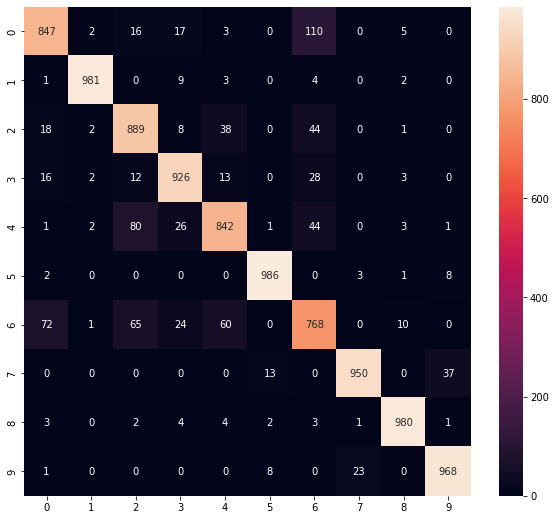

In [41]:
plt.figure(figsize=(10,9))
sns.heatmap(cm, annot=True, fmt="d")